In [1]:
# -*- coding: utf-8 -*-
# learning & evaluation
# author: Cheng Zheng

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine learning algorithms
from sklearn.linear_model import Ridge  # Ridge regression
from sklearn.kernel_ridge import KernelRidge  # Kernel ridge regression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor  # AdaBoost & Random Forest
from sklearn.neural_network import MLPRegressor  # Neural network
from sklearn.svm import SVR  # Support vector machine

# Cross-validation
'''
GridSearchCV = Perform an optimization of the parameters.
                1. search for the best parameters for model; 
                2. automatically fit a new model on the training dataset w/ the parameters that 
                    can yield the best cross-validation performance.
cross_val_score = to implement cross-validation in scikit-learn.
PS: When an integer is passed to the cv parameter of cross_val_score():
    cv=int (same as cv=StratifiedKFold(n_splits=int)) is used if the estimator is a classifier 
    and y is either binary or multiclass; In all other cases, KFold is used.
'''
from sklearn.model_selection import GridSearchCV


In [ ]:
class learning(object): 
    
    def __init__(self, alg, rule, loadfile, savefile):
        # alg=algorithm; rule=evaluation method; loadfile=preprocessed data excel; savefile=folder to store plots
        self.alg = alg
        self.rule = rule
        self.loadfile = loadfile
        self.savefile = savefile

    def param(self):
        # i=check what y sets, aka MVPA or Total Area; j=check how many variables in X, aka 5 or 1;
        # k=check preprocessing method, aka StandardScaler or MinMaxScaler
        i = 1 if ('y_MVPA' in self.savefile) else 0
        j = 0 if (('x_MVPA_y_totalArea' in self.savefile) or ('x_totalArea_y_MVPA' in self.savefile)) else 1
        k = 1 if ('/standardScaler' in self.loadfile) else 0 
        return i, j, k
        
    # Import dataset
    def loadDatasets(self):
        path = os.getcwd()#get current path
        path_up1Dir = os.path.dirname(path)#go up one directory
        dataset = pd.read_excel(path_up1Dir + self.loadfile)#to import the preprocessed dataset into a variable
        
        i = self.param()[0]
        j = self.param()[1]
        k = self.param()[2]
        
        if (i == 1):
            X = pd.DataFrame(dataset.iloc[:,4:9]) if (j == 1) else dataset['aveTotalArea'].values.reshape(-1, 1)
        else:
            X = pd.DataFrame(dataset.iloc[:,5:10]) if (j == 1) else dataset['MVPA'].values.reshape(-1, 1)
        y = dataset['MVPA'] if (i == 1) else dataset['aveTotalArea']
        other = pd.DataFrame(dataset.iloc[:,:4])
        
        return X, y, other, path_up1Dir

    # Which algorithm
    def algorithm(self):
        alg_dict = {
            'ridge': Ridge(),
            'kr': KernelRidge(),
            'svr': SVR(),
            'nn': MLPRegressor(),
            'rf': RandomForestRegressor(),
            'ab': AdaBoostRegressor(),
        }
        model = alg_dict.get(self.alg)
            
        return model
        
    # Set param_grid, aka the main parameters in dict
    def param_grid(self):
        '''
        np.logspace = to create geometric series, start and end w/ powers of 10, 
                      i.e. logspace(-2,1,4): a geometric sequence starts w/ 10^-2, ends w/ 10^1, and contains 4 elements.
        np.arange = also to create an arithmetic array, 
                      i.e. arange(1,12,5)): a arithmetic array looks like [1, 6, 11].
        '''
        a = 10.0 ** -np.arange(1, 7)
        
        param_grid_dict = {
            'ridge': [
                {'alpha':np.logspace(-6,6,13)},
                {'alpha':np.arange(1,1001,100)}
            ],
            
            'kr': [
                {'kernel':['rbf'],
                 'gamma':np.logspace(-2,2,5),
                 'alpha':np.logspace(-6,6,13)},
                {'kernel':['linear'],
                 'alpha':np.logspace(-6,6,13)}
            ],
            
            'svr': [
                {'kernel': ['linear'],
                 'C': np.logspace(0,3,4),
                 'coef0': np.linspace(0,5,10)},
                {'kernel': ['rbf'],
                 'gamma': np.logspace(-10,1,20),
                 'C': np.logspace(0,3,4),
                 'coef0': np.linspace(0,5,10)},
            ],
            
            'nn': 
                {'alpha': a,
                 'max_iter': [10000]}
            ,
            
            'rf': 
                {'n_estimators':np.arange(10,101,10),
                 'max_features':np.arange(0.1,1.1,0.1),
                 'max_depth':np.arange(1,11),
                 #'min_samples_split':np.arange(2,10),
                 'bootstrap':[True,False]}
            ,
            
            'ab': 
                {'n_estimators':np.arange(10,201,10),
                 'learning_rate':np.arange(0.1,1.1,0.1)}
            ,
        }
        param_grid = param_grid_dict.get(self.alg)

        return param_grid

        
    # GridSearchCV to find optimal parameters
    def gridSearchCV_eval(self):
        i = self.param()[0]
        j = self.param()[1]
        k = self.param()[2]
        
        i_ = 'y_MVPA' if (i == 1) else 'y_totalArea'
        j_ = '5Xs' if (j == 1) else '1X'
        k_ = 'StandardScaler' if (k == 1) else 'MinMaxScaler'
        
        X = self.loadDatasets()[0]
        y = self.loadDatasets()[1] if ((self.alg == 'ridge') or (self.alg == 'kr')) else self.loadDatasets()[1].values.ravel()
        
        grid = GridSearchCV(estimator=self.algorithm(), # algorithm
                            param_grid=self.param_grid(), # specify the parameters to search over using a dict
                            cv=10, # 10-Fold
                            scoring=self.rule # evaluation method
                            )

        # Build the model, aka training the dataset
        grid.fit(X, y)
        
        # Output the best parameter, cross-validation score, estimator, and the index of best estimator.
        print("Best score in %s: {:.2f}".format(grid.best_score_) %self.rule)
#         print("Best parameter: {}".format(grid.best_params_))
#         print("Best estimator: {}".format(grid.best_estimator_))
#         print("Average score in 10-Fold: \n", grid.cv_results_['mean_test_score'])
#         print("Std score in 10-Fold: \n", grid.cv_results_['std_test_score'])
#         print("The Index of Best estimator: {}".format(grid.best_index_))
        
        #######################
        # Draw the plot w/ y_true VS y_pred
        if (self.rule == 'r2'):
#             ave_score_cv = cross_val_score(grid, X, y, cv=10, scoring=self.rule).mean()
#             print("average r2 score in 10-Fold: ", ave_score_cv)
            yhat = grid.predict(X)
            sorted(y)

            plt.figure(dpi=100)
            plt.title("Scatter Plot: %s Model %s %s %s" %(self.algorithm(), i_, j_, k_))
            plt.scatter(x=y, y=yhat, alpha=0.25)
            plt.xlabel('Actual') 
            plt.ylabel('Predicted')
            plt.xticks(range(-1,9,1))
            plt.yticks(range(-1,11,1))
            plt.grid(True)
            #plt.savefig(fname=self.loadDatasets()[3] + self.savefile + "/scatter_%s.png" %self.algorithm())
            plt.show()

#     # 10-Fold cross-validation to check its accuracy
#     def cross_val(self): 
#         X = self.loadDatasets()[0]
#         if (self.alg == 'ridge' or self.alg == 'kr'):
#             y = self.loadDatasets()[1]
#         else:
#             y = self.loadDatasets()[1].values.ravel()
        
#         score = cross_val_score(estimator=self.gridSearchCV()[0],
#                             X=X, y=y,
#                             cv=10,
#                             scoring=self.rule
#                            )
#         print("\nBest score in %s:" %self.rule, score)
        
#     # Use the above optimal parameters to build new model, aka training the dataset
#     def fit(self):
#         fit = self.gridSearchCV()[0].fit(self.loadDatasets()[0], self.loadDatasets()[1])


In [ ]:
if __name__ == '__main__':
    algs = ['ab', 'rf', 'nn', 'svr'] # ['ridge', 'kr', 'ab', 'rf', 'nn', 'svr']
    rules = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'] # ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
    
    ss = '/standardScaler'
    ss_xlsx = ss+'/standardScaler.xlsx'
    ss_savefiles = [ss+'/x_MVPA_y_totalArea', ss+'/x_totalArea_y_MVPA', ss+'/y_totalArea', ss+'/y_MVPA']
    
    mms = '/minMaxScaler'
    mms_xlsx = mms+'/minMaxScaler.xlsx'
    mms_savefiles = [mms+'/x_MVPA_y_totalArea', mms+'/x_totalArea_y_MVPA', mms+'/y_totalArea', mms+'/y_MVPA']
    
    for alg in algs:
        alg_dict = {
            'ridge': 'Ridge',
            'kr': 'Kernel Ridge',
            'svr': 'Support Vector Machine',
            'nn': 'Neural Network',
            'rf': 'Random Forest',
            'ab': 'AdaBoost',
        }
        model = alg_dict.get(alg)
        
        print("\n------------------ %s Model ------------------" %model)
        for ss_savefile in ss_savefiles:
            print(ss_savefile)
            for rule in rules:
                test = learning(alg, rule, ss_xlsx, ss_savefile)
                test.gridSearchCV_eval()
        for mms_savefile in mms_savefiles:
            print(mms_savefile)
            for rule in rules:
                test = learning(alg, rule, mms_xlsx, mms_savefile)
                test.gridSearchCV_eval()

In [2]:
class plot(object):
    
    def __init__(self, loadfile, savefile): # alg = algorithm name, rule = evaluation method
        self.loadfile = loadfile
        self.savefile = savefile

    def param(self):
        i = 1 if ('y_MVPA' in self.savefile) else 0 # check what y sets, MVPA or Total Area
        j = 0 if (('x_MVPA_y_totalArea' in self.savefile) or ('x_totalArea_y_MVPA' in self.savefile)) else 1 # check how many variables in X, 5 or 1
        k = 1 if ('/standardScaler' in self.loadfile) else 0 # check preprocessing method, StandardScaler or MinMaxScaler
        return i, j, k

    # Import dataset
    def loadDatasets(self):
        path = os.getcwd()#get current path
        path_up1Dir = os.path.dirname(path)#go up one directory
        dataset = pd.read_excel(path_up1Dir + self.loadfile)#to import the preprocessed dataset into a variable
        
        i = self.param()[0]
        j = self.param()[1]
        k = self.param()[2]
        
        y = dataset['MVPA_minutes.week'] if (i == 1) else dataset['aveTotalArea']
        if (i == 1):
            X = pd.DataFrame(dataset.iloc[:,0:5]) if (j == 1) else dataset['aveTotalArea'].values.reshape(-1, 1)
        else:
            X = pd.DataFrame(dataset.iloc[:,1:6]) if (j == 1) else dataset['MVPA_minutes.week'].values.reshape(-1, 1)
        
        return X, y, path_up1Dir
    
    def scatter(self):
        i = self.param()[0]
        j = self.param()[1]
        k = self.param()[2]
        
        i_ = 'y_MVPA' if (i == 1) else 'y_totalArea'
        j_ = '5Xs' if (j == 1) else '1X'
        k_ = 'StandardScaler' if (k == 1) else 'MinMaxScaler'
        
        X = self.loadDatasets()[0]
        y = self.loadDatasets()[1]

        plt.figure(dpi=100)
        plt.title("Scatter Plot: original X vs y %s %s" %(i_, j_))
        if (j == 1):
            indexs = np.arange(0,5)
            color_dict = {
                '0':'r',
                '1':'y',
                '2':'b',
                '3':'g',
                '4':'m',
            }
            for index in indexs:
                plt.scatter(x=X.iloc[:,index], y=y, alpha=0.15, color=color_dict.get(index), label=X.columns[index])
        else:
            plt.scatter(x=X, y=y, alpha=0.25, label='x_totalArea' if (i == 1) else ('x_MVPA'))
        plt.xlabel(j_) 
        plt.ylabel(i_)
        plt.grid(True)
        plt.legend()
        plt.savefig(fname=self.loadDatasets()[2] + "/original/scatter_original_data_%s_%s.png" %(i_, j_))
        plt.show()

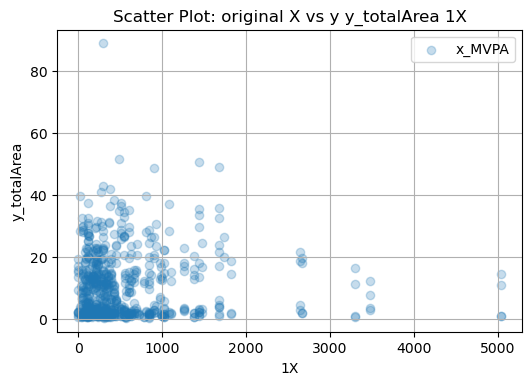

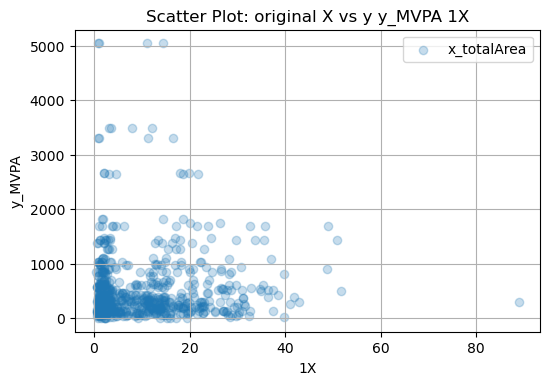

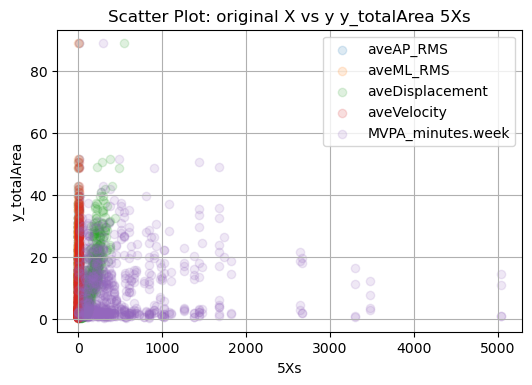

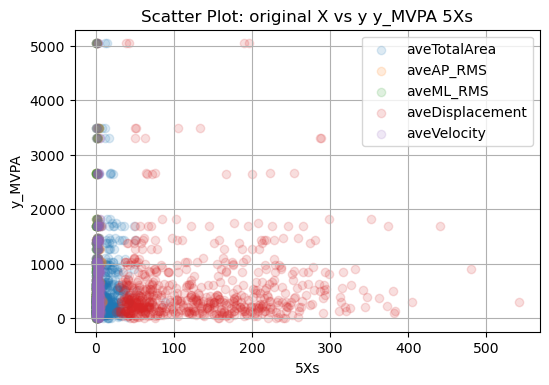

In [3]:
if __name__ == '__main__':
    mms = '/minMaxScaler'
    mms_savefiles = [mms+'/x_MVPA_y_totalArea', mms+'/x_totalArea_y_MVPA', mms+'/y_totalArea', mms+'/y_MVPA']

    for mms_savefile in mms_savefiles:
        test = plot('/BDS/variables.xlsx', mms_savefile)
        test.scatter()